In [20]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from matplotlib.patches import Patch

#from setup_japanese_font import setup_japanese_font
#setup_japanese_font()


# Google Driveを使う場合は以下を先に実行
# from google.colab import drive
# drive.mount('/content/drive')
# results_path = '/content/drive/MyDrive/GrayScottML/results/analysis_results_phase2.pkl'

results_path = '/Users/miura/Library/CloudStorage/GoogleDrive-miuratakashilab@gmail.com/マイドライブ/GrayScottML/phase2_results_gpu.pkl'  # パスを適宜修正

with open(results_path, 'rb') as f:
    results = pickle.load(f)

latent_vectors = results['latent_vectors']
f_values = results['f_values']
k_values = results['k_values']

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(latent_vectors)
silhouette = silhouette_score(latent_vectors, cluster_labels)
print(f"Silhouette Score (k=3): {silhouette:.3f}")

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(latent_vectors)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(latent_vectors)


Silhouette Score (k=3): 0.434


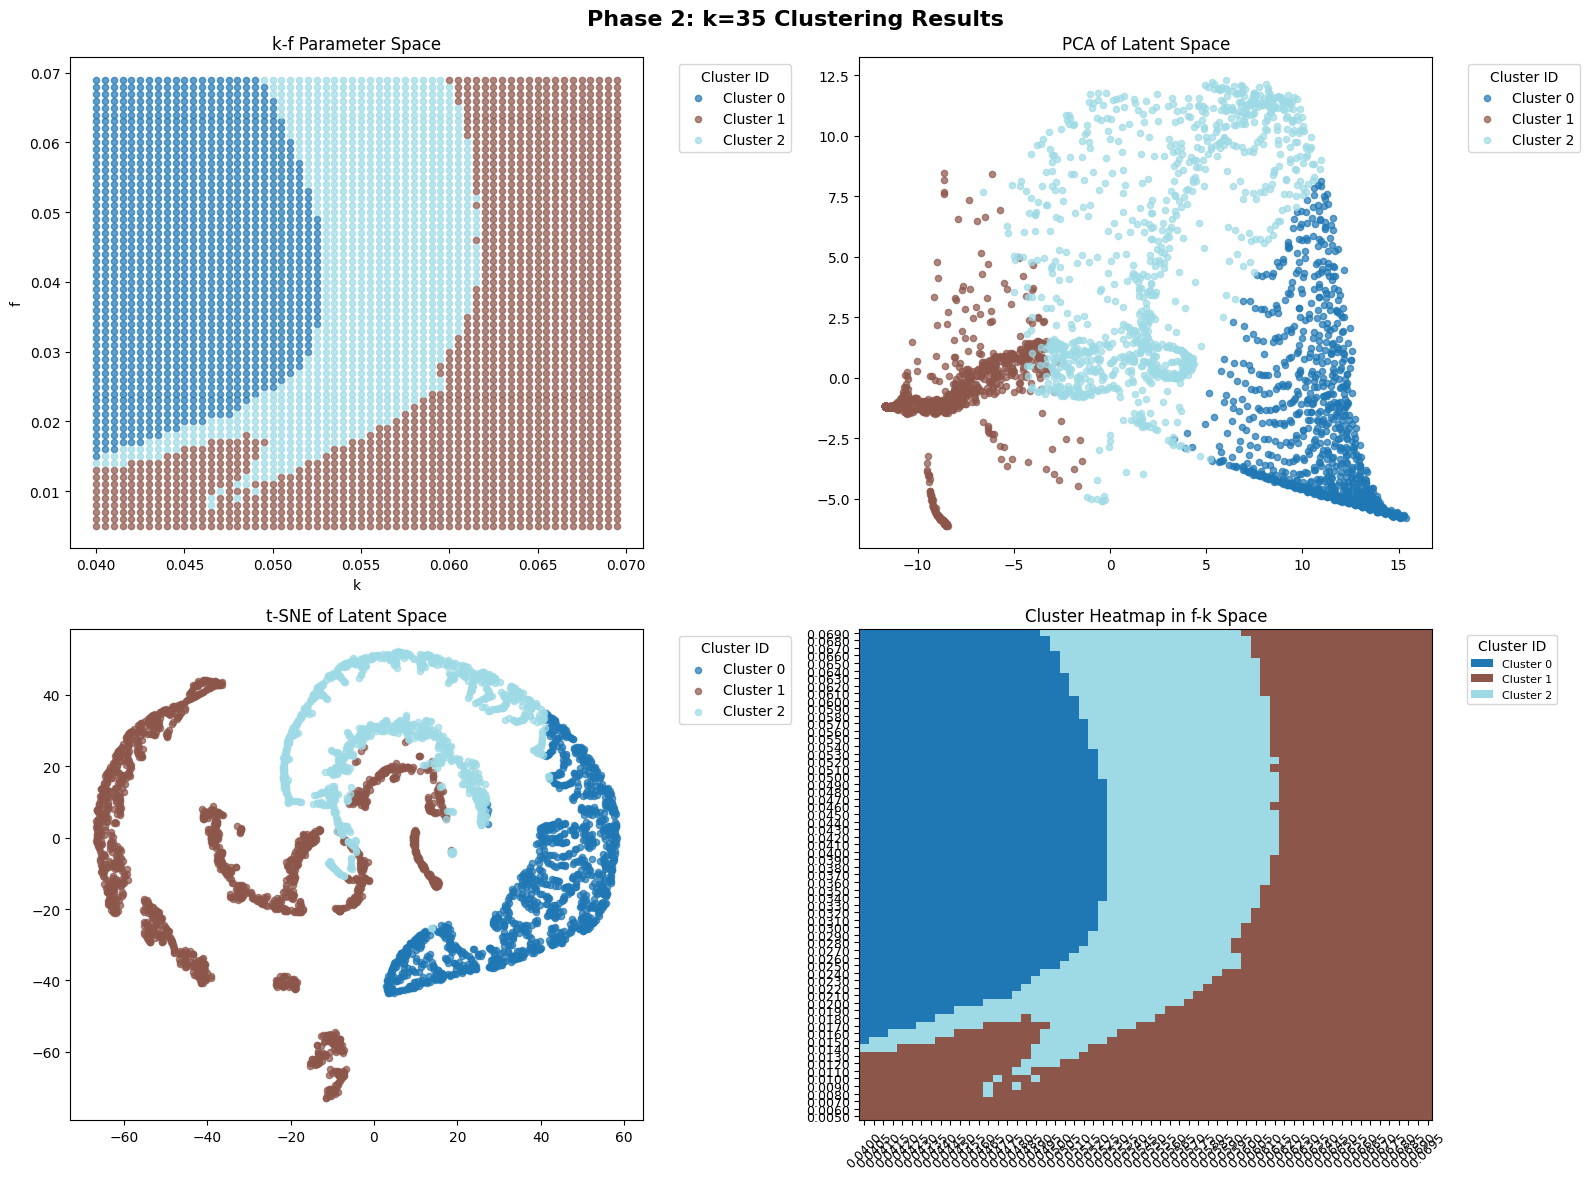

In [21]:
# 元のコードを以下のように修正
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Phase 2: k=35 Clustering Results', fontsize=16, fontweight='bold')

# 色の統一
colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))

# f-k空間でのクラスタリング結果
for i in range(n_clusters):
    mask = cluster_labels == i
    axes[0, 0].scatter(k_values[mask], f_values[mask], 
                      c=[colors[i]], alpha=0.7, s=20, 
                      label=f'Cluster {i}')
axes[0, 0].set_xlabel('k')
axes[0, 0].set_ylabel('f')
axes[0, 0].set_title('k-f Parameter Space')
axes[0, 0].legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# PCA空間でのクラスタリング結果
for i in range(n_clusters):
    mask = cluster_labels == i
    axes[0, 1].scatter(pca_result[mask, 0], pca_result[mask, 1], 
                      c=[colors[i]], alpha=0.7, s=20, 
                      label=f'Cluster {i}')
axes[0, 1].set_title('PCA of Latent Space')
axes[0, 1].legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# t-SNE空間でのクラスタリング結果
for i in range(n_clusters):
    mask = cluster_labels == i
    axes[1, 0].scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                      c=[colors[i]], alpha=0.7, s=20, 
                      label=f'Cluster {i}')
axes[1, 0].set_title('t-SNE of Latent Space')
axes[1, 0].legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# ヒートマップ（右下）
f_unique = np.unique(f_values)
k_unique = np.unique(k_values)
heatmap_data = np.full((len(f_unique), len(k_unique)), np.nan)
for i, f in enumerate(f_values):
    k = k_values[i]
    cluster = cluster_labels[i]
    f_idx = np.where(f_unique == f)[0][0]
    k_idx = np.where(k_unique == k)[0][0]
    heatmap_data[f_idx, k_idx] = cluster

im = axes[1, 1].imshow(heatmap_data, cmap='tab20', aspect='auto', origin='lower', 
                      vmin=0, vmax=n_clusters-1)
axes[1, 1].set_title('Cluster Heatmap in f-k Space')

# x軸（k）・y軸（f）に実際の値をラベルとして表示
axes[1, 1].set_xticks(range(len(k_unique)))
axes[1, 1].set_yticks(range(len(f_unique)))
axes[1, 1].set_xticklabels([f'{k:.4f}' for k in k_unique], rotation=45, fontsize=9)
axes[1, 1].set_yticklabels([f'{f:.4f}' for f in f_unique], fontsize=9)

# ヒートマップ用のLegend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], label=f'Cluster {i}') 
                  for i in range(n_clusters)]
axes[1, 1].legend(handles=legend_elements, title='Cluster ID', 
                 bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [22]:
from torchsummary import summary
from src.gray_scott_autoencoder_phase2 import Conv3DAutoencoderPhase2

model = Conv3DAutoencoderPhase2(input_channels=1, fixed_frames=30, target_size=(64, 64), latent_dim=256)
summary(model, (1, 30, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 30, 32, 32]           4,736
       BatchNorm3d-2       [-1, 32, 30, 32, 32]              64
              ReLU-3       [-1, 32, 30, 32, 32]               0
         Dropout3d-4       [-1, 32, 30, 32, 32]               0
            Conv3d-5       [-1, 64, 15, 16, 16]          55,296
       BatchNorm3d-6       [-1, 64, 15, 16, 16]             128
         Dropout3d-7       [-1, 64, 15, 16, 16]               0
            Conv3d-8       [-1, 64, 15, 16, 16]         110,592
       BatchNorm3d-9       [-1, 64, 15, 16, 16]             128
AdaptiveAvgPool3d-10         [-1, 64, 15, 1, 1]               0
           Conv3d-11         [-1, 16, 15, 1, 1]           1,040
             ReLU-12         [-1, 16, 15, 1, 1]               0
           Conv3d-13         [-1, 64, 15, 1, 1]           1,088
          Sigmoid-14         [-1, 64, 1

クラスター0のサンプル数: 1034
全体に占める割合: 26.5%


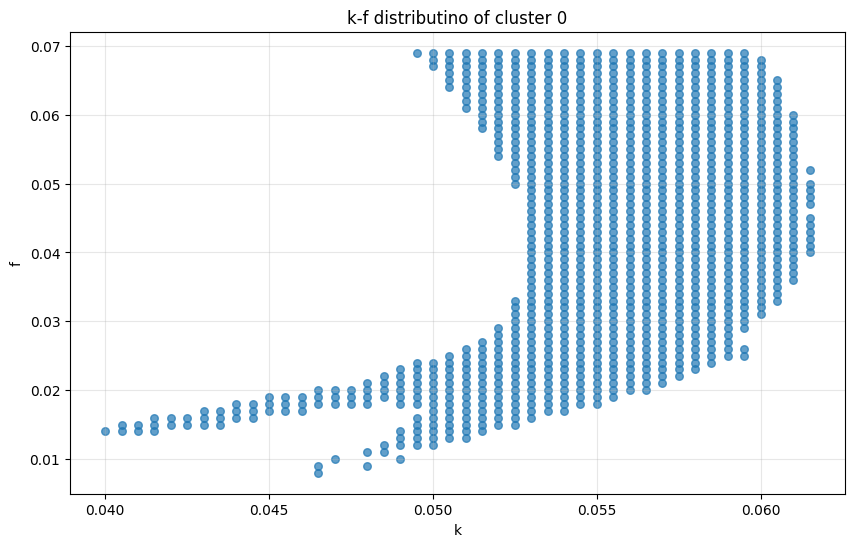

f値の範囲: 0.0080 - 0.0690
k値の範囲: 0.0400 - 0.0615


In [23]:
# クラスター0のデータを抽出
cluster_0_mask = cluster_labels == 2
cluster_0_indices = np.where(cluster_0_mask)[0]
cluster_0_latent = latent_vectors[cluster_0_mask]
cluster_0_f_values = f_values[cluster_0_mask]
cluster_0_k_values = k_values[cluster_0_mask]

print(f"クラスター0のサンプル数: {len(cluster_0_indices)}")
print(f"全体に占める割合: {len(cluster_0_indices)/len(cluster_labels)*100:.1f}%")

# クラスター0のf-k分布を確認
plt.figure(figsize=(10, 6))
plt.scatter(cluster_0_k_values, cluster_0_f_values, alpha=0.7, s=30)
plt.xlabel('k')
plt.ylabel('f')
plt.title('k-f distributino of cluster 0')
plt.grid(True, alpha=0.3)
plt.show()

# クラスター0の統計情報
print(f"f値の範囲: {cluster_0_f_values.min():.4f} - {cluster_0_f_values.max():.4f}")
print(f"k値の範囲: {cluster_0_k_values.min():.4f} - {cluster_0_k_values.max():.4f}")


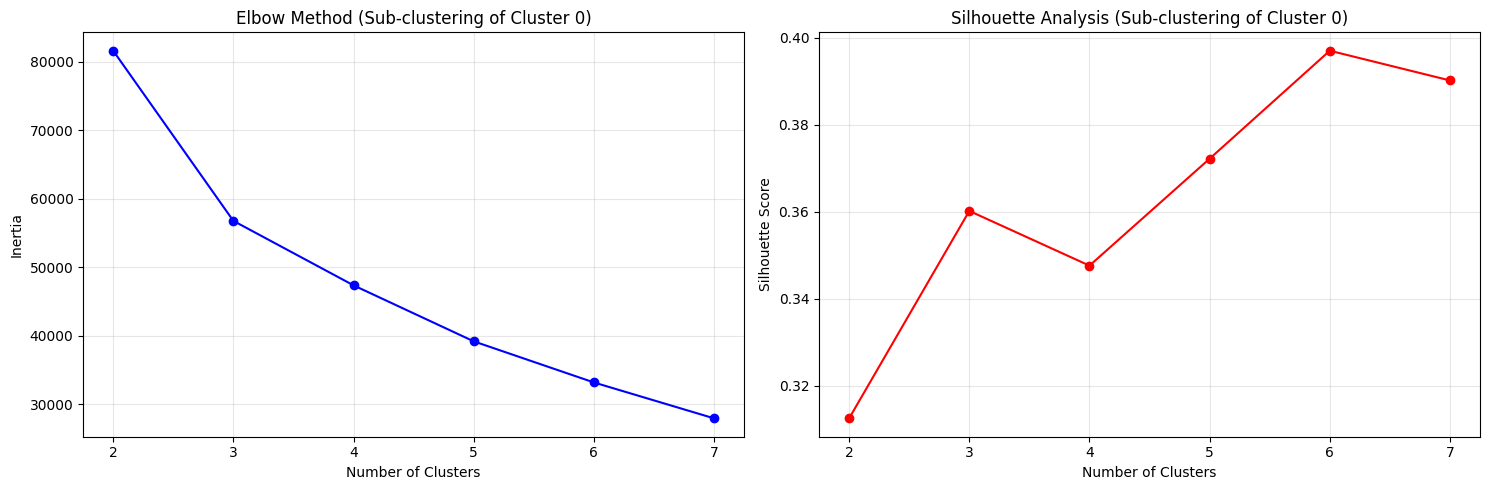

最適なサブクラスター数: 6
最大シルエット係数: 0.397

クラスター数とシルエット係数:
k=2: 0.313
k=3: 0.360
k=4: 0.348
k=5: 0.372
k=6: 0.397
k=7: 0.390


In [24]:
# クラスター0のサブクラスタリング
# 最適なクラスター数を決定するためのエルボー法とシルエット分析

from sklearn.metrics import silhouette_score

# クラスター数の候補
k_range = range(2, 8)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans_sub = KMeans(n_clusters=k, random_state=42, n_init=10)
    sub_labels = kmeans_sub.fit_predict(cluster_0_latent)
    inertias.append(kmeans_sub.inertia_)
    silhouette_scores.append(silhouette_score(cluster_0_latent, sub_labels))

# 結果をプロット
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# エルボー法
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method (Sub-clustering of Cluster 0)')
ax1.grid(True, alpha=0.3)

# シルエット分析
ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis (Sub-clustering of Cluster 0)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 最適なクラスター数を選択（シルエット係数が最大のもの）
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"最適なサブクラスター数: {optimal_k}")
print(f"最大シルエット係数: {max(silhouette_scores):.3f}")

# シルエット係数の詳細表示
print("\nクラスター数とシルエット係数:")
for k, score in zip(k_range, silhouette_scores):
    print(f"k={k}: {score:.3f}")


In [25]:
optimal_k=12

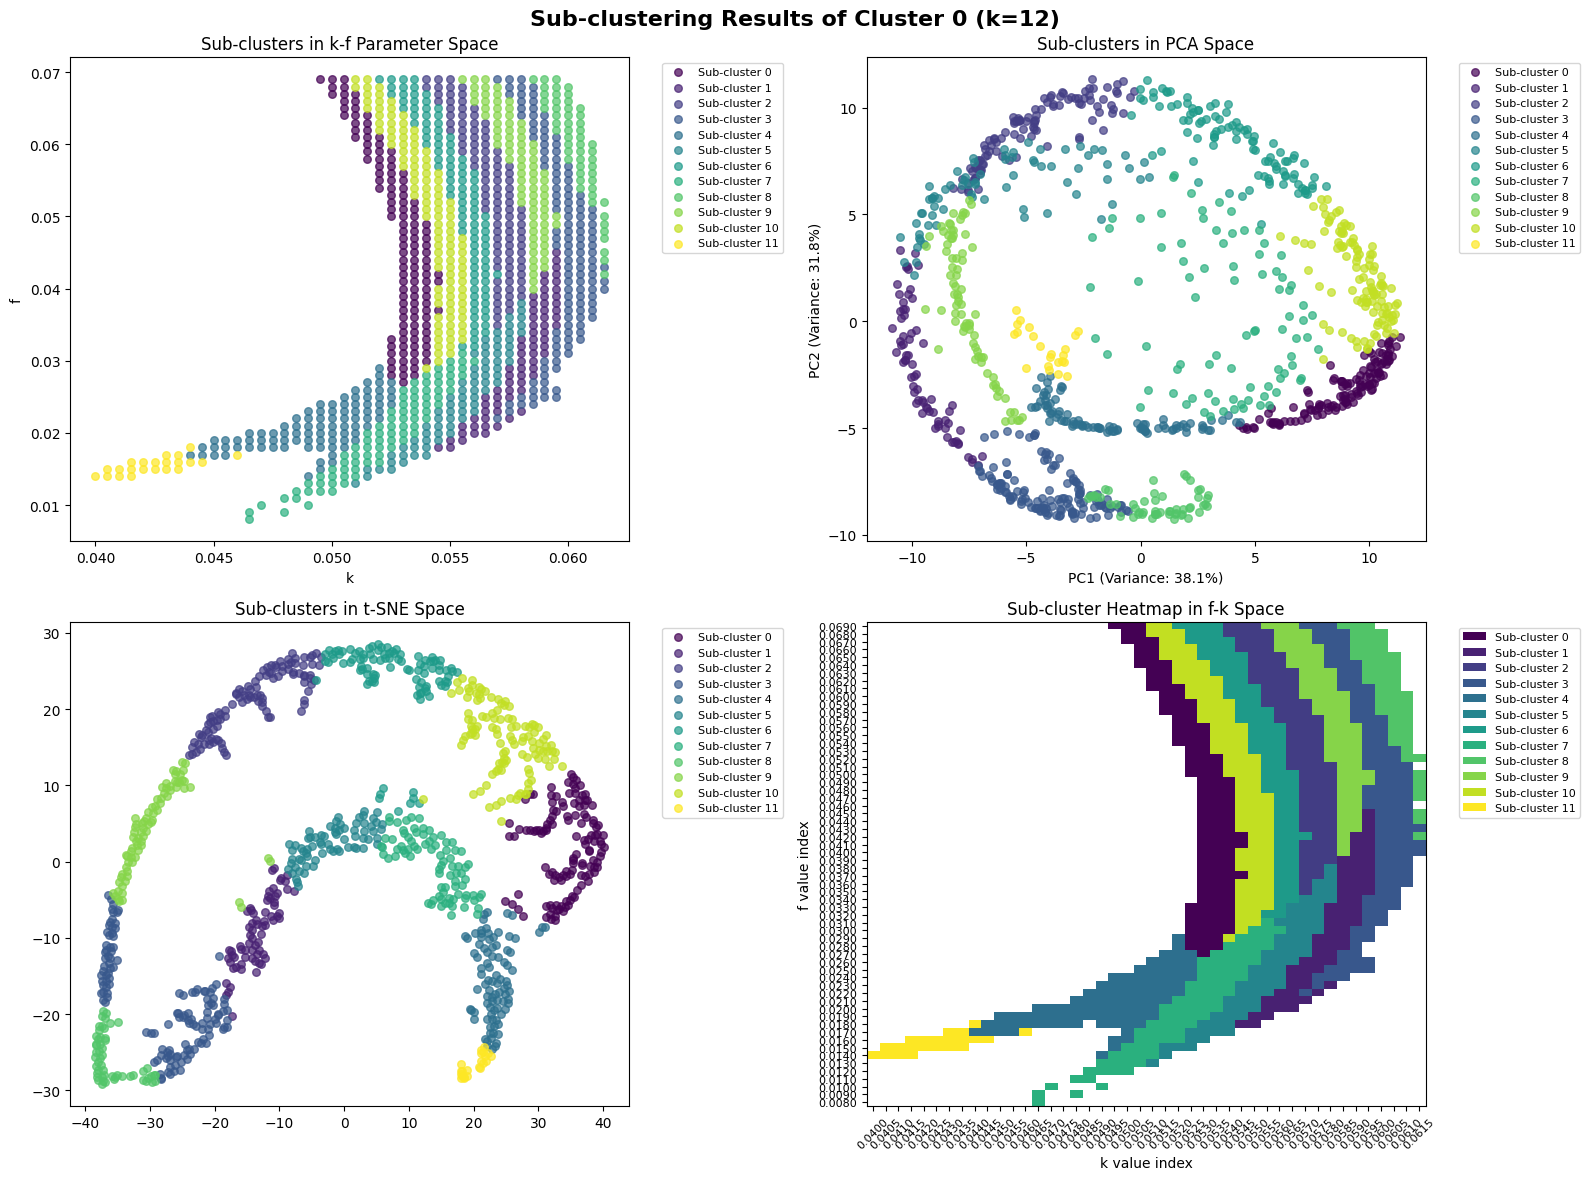

In [30]:
# 最適なクラスター数でサブクラスタリングを実行
kmeans_sub = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
sub_cluster_labels = kmeans_sub.fit_predict(cluster_0_latent)

# サブクラスターの可視化
# PCAとt-SNEを使用して次元削減
pca_sub = PCA(n_components=2, random_state=42)
pca_sub_result = pca_sub.fit_transform(cluster_0_latent)

tsne_sub = TSNE(n_components=2, random_state=42, perplexity=min(30, len(cluster_0_latent)//4))
tsne_sub_result = tsne_sub.fit_transform(cluster_0_latent)

# サブクラスターの可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Sub-clustering Results of Cluster 0 (k={optimal_k})', fontsize=16, fontweight='bold')

# Create colors for each sub-cluster
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))

# f-k space sub-clusters
for i in range(optimal_k):
    mask = sub_cluster_labels == i
    axes[0, 0].scatter(cluster_0_k_values[mask], cluster_0_f_values[mask], 
                      c=[colors[i]], alpha=0.7, s=30, label=f'Sub-cluster {i}')
axes[0, 0].set_xlabel('k')
axes[0, 0].set_ylabel('f')
axes[0, 0].set_title('Sub-clusters in k-f Parameter Space')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# PCA space sub-clusters
for i in range(optimal_k):
    mask = sub_cluster_labels == i
    axes[0, 1].scatter(pca_sub_result[mask, 0], pca_sub_result[mask, 1], 
                      c=[colors[i]], alpha=0.7, s=30, label=f'Sub-cluster {i}')
axes[0, 1].set_title('Sub-clusters in PCA Space')
axes[0, 1].set_xlabel(f'PC1 (Variance: {pca_sub.explained_variance_ratio_[0]:.1%})')
axes[0, 1].set_ylabel(f'PC2 (Variance: {pca_sub.explained_variance_ratio_[1]:.1%})')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# t-SNE space sub-clusters
for i in range(optimal_k):
    mask = sub_cluster_labels == i
    axes[1, 0].scatter(tsne_sub_result[mask, 0], tsne_sub_result[mask, 1], 
                      c=[colors[i]], alpha=0.7, s=30, label=f'Sub-cluster {i}')
axes[1, 0].set_title('Sub-clusters in t-SNE Space')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Sub-cluster heatmap in f-k space
f_unique_sub = np.unique(cluster_0_f_values)
k_unique_sub = np.unique(cluster_0_k_values)
heatmap_sub = np.full((len(f_unique_sub), len(k_unique_sub)), np.nan)

for i, (f, k, label) in enumerate(zip(cluster_0_f_values, cluster_0_k_values, sub_cluster_labels)):
    f_idx = np.where(f_unique_sub == f)[0][0]
    k_idx = np.where(k_unique_sub == k)[0][0]
    heatmap_sub[f_idx, k_idx] = label

im = axes[1, 1].imshow(heatmap_sub, cmap='viridis', aspect='auto', origin='lower', 
                      vmin=0, vmax=optimal_k-1)
axes[1, 1].set_title('Sub-cluster Heatmap in f-k Space')
axes[1, 1].set_xlabel('k value index')
axes[1, 1].set_ylabel('f value index')

# Set axis labels to actual values
axes[1, 1].set_xticks(range(len(k_unique_sub)))
axes[1, 1].set_yticks(range(len(f_unique_sub)))
axes[1, 1].set_xticklabels([f'{k:.4f}' for k in k_unique_sub], rotation=45, fontsize=8)
axes[1, 1].set_yticklabels([f'{f:.4f}' for f in f_unique_sub], fontsize=8)

# Create custom legend for heatmap
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], label=f'Sub-cluster {i}') 
                  for i in range(optimal_k)]
axes[1, 1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()


In [27]:
# サブクラスターの詳細統計情報を表示
print("Sub-cluster Detailed Statistics:")
print("=" * 60)

for i in range(optimal_k):
    mask = sub_cluster_labels == i
    count = np.sum(mask)
    f_mean = cluster_0_f_values[mask].mean()
    f_std = cluster_0_f_values[mask].std()
    k_mean = cluster_0_k_values[mask].mean()
    k_std = cluster_0_k_values[mask].std()
    
    print(f"\nSub-cluster {i}:")
    print(f"  Sample count: {count}")
    print(f"  Percentage: {count/len(cluster_0_latent)*100:.1f}%")
    print(f"  f-value: {f_mean:.4f} ± {f_std:.4f}")
    print(f"  k-value: {k_mean:.4f} ± {k_std:.4f}")
    print(f"  f-range: [{cluster_0_f_values[mask].min():.4f}, {cluster_0_f_values[mask].max():.4f}]")
    print(f"  k-range: [{cluster_0_k_values[mask].min():.4f}, {cluster_0_k_values[mask].max():.4f}]")


Sub-cluster Detailed Statistics:

Sub-cluster 0:
  Sample count: 126
  Percentage: 12.2%
  f-value: 0.0467 ± 0.0121
  k-value: 0.0528 ± 0.0011
  f-range: [0.0270, 0.0690]
  k-range: [0.0495, 0.0545]

Sub-cluster 1:
  Sample count: 70
  Percentage: 6.8%
  f-value: 0.0304 ± 0.0074
  k-value: 0.0579 ± 0.0013
  f-range: [0.0180, 0.0450]
  k-range: [0.0545, 0.0595]

Sub-cluster 2:
  Sample count: 104
  Percentage: 10.1%
  f-value: 0.0535 ± 0.0095
  k-value: 0.0566 ± 0.0010
  f-range: [0.0350, 0.0690]
  k-range: [0.0540, 0.0580]

Sub-cluster 3:
  Sample count: 130
  Percentage: 12.6%
  f-value: 0.0459 ± 0.0130
  k-value: 0.0596 ± 0.0010
  f-range: [0.0220, 0.0690]
  k-range: [0.0570, 0.0615]

Sub-cluster 4:
  Sample count: 88
  Percentage: 8.5%
  f-value: 0.0210 ± 0.0032
  k-value: 0.0493 ± 0.0022
  f-range: [0.0140, 0.0290]
  k-range: [0.0440, 0.0525]

Sub-cluster 5:
  Sample count: 71
  Percentage: 6.9%
  f-value: 0.0253 ± 0.0066
  k-value: 0.0555 ± 0.0018
  f-range: [0.0130, 0.0380]
  k-r

サブクラスターの詳細分析:

サブクラスター 0:
  サンプル数: 126
  全体に占める割合: 12.2%
  f値範囲: 0.0270 - 0.0690
  k値範囲: 0.0495 - 0.0545
  元データでのインデックス例: [14, 82, 91, 163, 187]

サブクラスター 1:
  サンプル数: 70
  全体に占める割合: 6.8%
  f値範囲: 0.0180 - 0.0450
  k値範囲: 0.0545 - 0.0595
  元データでのインデックス例: [20, 59, 108, 149, 280]

サブクラスター 2:
  サンプル数: 104
  全体に占める割合: 10.1%
  f値範囲: 0.0350 - 0.0690
  k値範囲: 0.0540 - 0.0580
  元データでのインデックス例: [41, 92, 95, 121, 123]

サブクラスター 3:
  サンプル数: 130
  全体に占める割合: 12.6%
  f値範囲: 0.0220 - 0.0690
  k値範囲: 0.0570 - 0.0615
  元データでのインデックス例: [33, 44, 143, 281, 330]

サブクラスター 4:
  サンプル数: 88
  全体に占める割合: 8.5%
  f値範囲: 0.0140 - 0.0290
  k値範囲: 0.0440 - 0.0525
  元データでのインデックス例: [18, 68, 272, 309, 523]

サブクラスター 5:
  サンプル数: 71
  全体に占める割合: 6.9%
  f値範囲: 0.0130 - 0.0380
  k値範囲: 0.0510 - 0.0580
  元データでのインデックス例: [99, 102, 171, 179, 216]

サブクラスター 6:
  サンプル数: 97
  全体に占める割合: 9.4%
  f値範囲: 0.0320 - 0.0690
  k値範囲: 0.0520 - 0.0570
  元データでのインデックス例: [48, 53, 114, 133, 146]

サブクラスター 7:
  サンプル数: 83
  全体に占める割合: 8.0%
  f値範囲: 0.0080 - 0.0310
  k値範囲

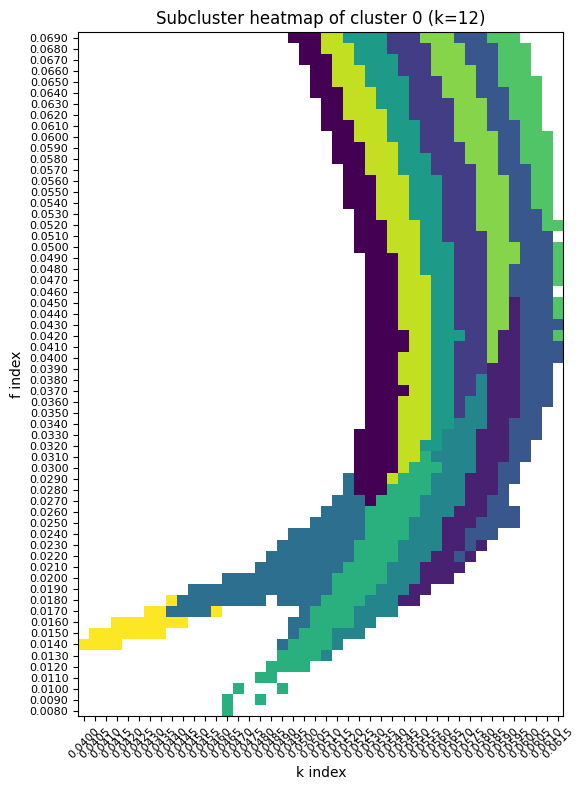

In [28]:
# サブクラスターの詳細分析とヒートマップ
print("サブクラスターの詳細分析:")
print("=" * 50)

# 各サブクラスターの特徴を分析
for i in range(optimal_k):
    mask = sub_cluster_labels == i
    indices = cluster_0_indices[mask]  # 元のデータセットでのインデックス
    
    print(f"\nサブクラスター {i}:")
    print(f"  サンプル数: {np.sum(mask)}")
    print(f"  全体に占める割合: {np.sum(mask)/len(cluster_0_latent)*100:.1f}%")
    print(f"  f値範囲: {cluster_0_f_values[mask].min():.4f} - {cluster_0_f_values[mask].max():.4f}")
    print(f"  k値範囲: {cluster_0_k_values[mask].min():.4f} - {cluster_0_k_values[mask].max():.4f}")
    print(f"  元データでのインデックス例: {indices[:5].tolist()}")

# サブクラスターのヒートマップを作成
plt.figure(figsize=(12, 8))

# f-k空間でのサブクラスターヒートマップ
f_unique_sub = np.unique(cluster_0_f_values)
k_unique_sub = np.unique(cluster_0_k_values)
heatmap_sub = np.full((len(f_unique_sub), len(k_unique_sub)), np.nan)

for i, (f, k, label) in enumerate(zip(cluster_0_f_values, cluster_0_k_values, sub_cluster_labels)):
    f_idx = np.where(f_unique_sub == f)[0][0]
    k_idx = np.where(k_unique_sub == k)[0][0]
    heatmap_sub[f_idx, k_idx] = label

im = plt.imshow(heatmap_sub, cmap='viridis', aspect='auto', origin='lower', 
                vmin=0, vmax=optimal_k-1)
plt.title(f'Subcluster heatmap of cluster 0 (k={optimal_k})')
plt.xlabel('k index')
plt.ylabel('f index')
# アスペクト比を1に設定
plt.gca().set_aspect('equal')

# 軸ラベルを実際の値に設定
plt.xticks(range(len(k_unique_sub)), [f'{k:.4f}' for k in k_unique_sub], rotation=45, fontsize=8)
plt.yticks(range(len(f_unique_sub)), [f'{f:.4f}' for f in f_unique_sub], fontsize=8)

#plt.colorbar(im, label='サブクラスターID')
plt.tight_layout()
plt.show()


In [29]:
# サブクラスターのデータを保存（必要に応じて）
sub_clustering_results = {
    'cluster_0_indices': cluster_0_indices,
    'sub_cluster_labels': sub_cluster_labels,
    'cluster_0_latent_vectors': cluster_0_latent,
    'cluster_0_f_values': cluster_0_f_values,
    'cluster_0_k_values': cluster_0_k_values,
    'optimal_k': optimal_k,
    'silhouette_scores': silhouette_scores,
    'pca_result': pca_sub_result,
    'tsne_result': tsne_sub_result,
    'kmeans_model': kmeans_sub
}

print("サブクラスタリング結果の要約:")
print(f"・クラスター0から {optimal_k} 個のサブクラスターを抽出")
print(f"・最適なクラスター数のシルエット係数: {max(silhouette_scores):.3f}")
print(f"・処理したサンプル数: {len(cluster_0_latent)}")

# 必要に応じて結果を保存
# import pickle
# with open('sub_clustering_results.pkl', 'wb') as f:
#     pickle.dump(sub_clustering_results, f)
# print("結果を sub_clustering_results.pkl に保存しました")

print("\n使用方法:")
print("・特定のサブクラスターのデータを取得: sub_cluster_labels == サブクラスターID")
print("・元データでのインデックス: cluster_0_indices[sub_cluster_labels == サブクラスターID]")
print("・さらに細かい分析が必要な場合は、特定のサブクラスターに対して同様の処理を実行可能")


サブクラスタリング結果の要約:
・クラスター0から 12 個のサブクラスターを抽出
・最適なクラスター数のシルエット係数: 0.397
・処理したサンプル数: 1034

使用方法:
・特定のサブクラスターのデータを取得: sub_cluster_labels == サブクラスターID
・元データでのインデックス: cluster_0_indices[sub_cluster_labels == サブクラスターID]
・さらに細かい分析が必要な場合は、特定のサブクラスターに対して同様の処理を実行可能
